### **Sobre el dataset:**

**`train_images:`** son las imágenes en sí, en este caso 60.000 imágenes de dígitos, cada una de **28×28 píxeles en escala de grises.

**`train_labels:`** son las etiquetas (clases) asociadas a cada imagen. Es decir, el número correcto que aparece en la imagen (0, 1, 2, …, 9).

### **1. Descargar desde Kaggle**

In [1]:
# 1. Instalar cliente de Kaggle e idx2numpy (para leer IDX fácil)
!pip -q install kaggle idx2numpy

# 2. Subir tu kaggle.json (al ejecutar abre un selector de archivos)
from google.colab import files
files.upload()  # <-- Seleccioná kaggle.json

# 3. Guardarlo con permisos correctos
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Descargar el dataset de MNIST (autor: hojjatk)
!mkdir -p /content/mnist
!kaggle datasets download -d hojjatk/mnist-dataset -p /content/mnist

# 5. Descomprimir
!unzip -q /content/mnist/*.zip -d /content/mnist

# 6. Ver qué archivos quedaron
!ls -lh /content/mnist


  Preparing metadata (setup.py) ... done


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/hojjatk/mnist-dataset
License(s): copyright-authors
  0% 0.00/22.0M [00:00<?, ?B/s]
100% 22.0M/22.0M [00:00<00:00, 1.02GB/s]
total 75M
-rw-r--r-- 1 root root  23M Oct 17  2019 mnist-dataset.zip
drwxr-xr-x 2 root root 4.0K Sep  3 21:51 t10k-images-idx3-ubyte
-rw-r--r-- 1 root root 7.5M Oct 17  2019 t10k-images.idx3-ubyte
drwxr-xr-x 2 root root 4.0K Sep  3 21:51 t10k-labels-idx1-ubyte
-rw-r--r-- 1 root root 9.8K Oct 17  2019 t10k-labels.idx1-ubyte
drwxr-xr-x 2 root root 4.0K Sep  3 21:51 train-images-idx3-ubyte
-rw-r--r-- 1 root root  45M Oct 17  2019 train-images.idx3-ubyte
drwxr-xr-x 2 root root 4.0K Sep  3 21:51 train-labels-idx1-ubyte
-rw-r--r-- 1 root root  59K Oct 17  2019 train-labels.idx1-ubyte


### **2) Cargar los archivos IDX y “ver” imágenes**


(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


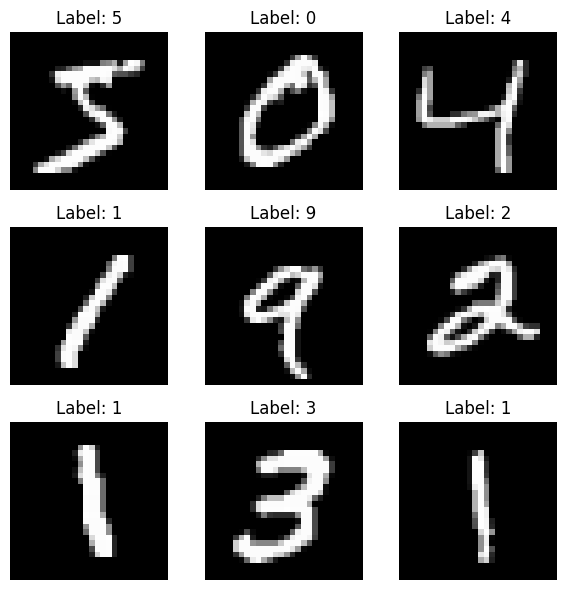

In [10]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt

# Rutas
base = "/content/mnist"
train_images = idx2numpy.convert_from_file(f"mnist/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = idx2numpy.convert_from_file(f"/content/mnist/train-labels-idx1-ubyte/train-labels-idx1-ubyte")
test_images  = idx2numpy.convert_from_file(f"/content/mnist/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels  = idx2numpy.convert_from_file(f"/content/mnist/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

print(train_images.shape, train_labels.shape)  # (60000, 28, 28) (60000,)
print(test_images.shape,  test_labels.shape)   # (10000, 28, 28) (10000,)

# Mostrar algunas imágenes de ejemplo
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


### **3) Preparar datos para Keras**

**Normalizamos** ya que las redes neuronales entrenan mejor y más rápido con valores pequeños y normalizados. Dividimos por 255 porque son los valores que tienen la imagen (0-255).

Además, a los datos los **expandimos** para que sean compatibles con Keras. Para imágenes grises es: **`(28, 28, 1)`**


In [11]:
# Normalizar a [0,1] y agregar canal (28x28x1)
x_train = train_images.astype("float32") / 255.0
x_test  = test_images.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)  # (60000, 28, 28, 1)
x_test  = np.expand_dims(x_test, -1)   # (10000, 28, 28, 1)

y_train = train_labels.astype("int64")
y_test  = test_labels.astype("int64")

x_train.shape, y_train.shape, x_test.shape, y_test.shape


((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

### **4) Definir una CNN simple en Keras y entrenar**

Nuestro input es **`(28, 28, 1)`**, debido a que nuestras imágenes tienen escala de grises

Hiperparámetros elegidos:

**`Conv2D(32, (3,3))`**

- Usa 32 filtros (o kernels), cada uno de tamaño 3×3.

- Cada filtro aprende a detectar una característica (bordes, curvas, texturas…).

**`Conv2D(64, (3,3))`**

- Ahora con 64 filtros (más capacidad para aprender patrones).

**`Dense(128)`**

- Es una capa totalmente conectada con 128 neuronas. Se usa para combinar toda la información extraída de las convoluciones y preparar la clasificación.

**`Dense(10, softmax)`**

- 10 salidas → porque hay 10 dígitos posibles (0–9).

- **`softmax`** da la probabilidad de que la imagen pertenezca a cada clase.

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# EarlyStopping: Monitorea el accuracy. Si ve que durante patience epochs no mejora, detiene el entrenamiento.
# restore_best_weights = True → al final deja el modelo en el mejor estado (no en el último).
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

history = model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 94ms/step - accuracy: 0.7785 - loss: 0.6868 - val_accuracy: 0.9832 - val_loss: 0.0619
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 40s 94ms/step - accuracy: 0.9661 - loss: 0.1175 - val_accuracy: 0.9873 - val_loss: 0.0440
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 39s 94ms/step - accuracy: 0.9763 - loss: 0.0792 - val_accuracy: 0.9888 - val_loss: 0.0386
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - accuracy: 0.9805 - loss: 0.0638 - val_accuracy: 0.9917 - val_loss: 0.0320
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 40s 95ms/step - accuracy: 0.9841 - loss: 0.0522 - val_accuracy: 0.9908 - val_loss: 0.0320


### **5. Evaluar y ver predicciones**


Test accuracy: 0.9904
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


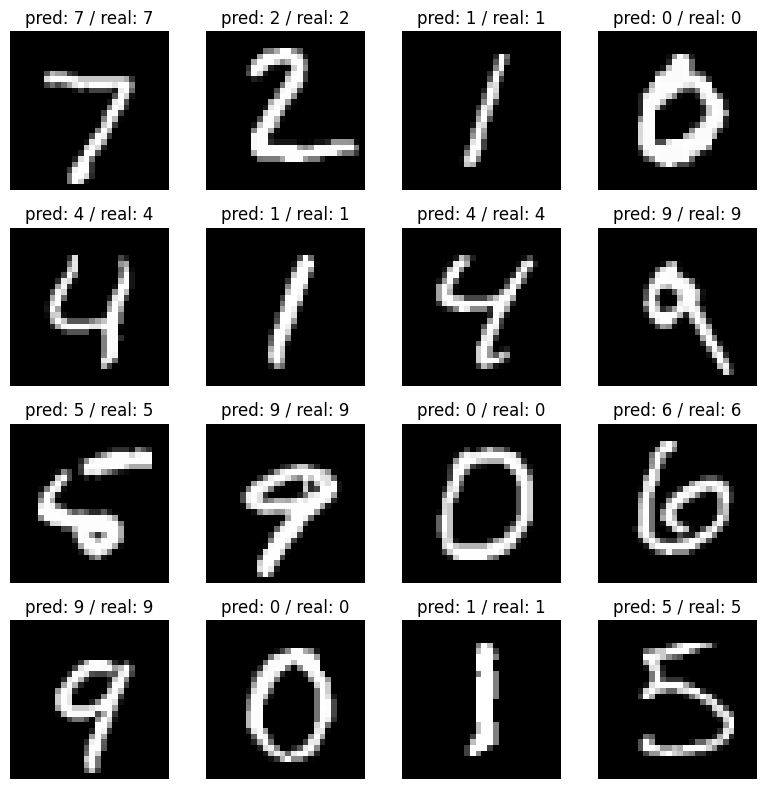

In [14]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

# Predicciones de algunas imágenes de test
probs = model.predict(x_test[:16])
preds = probs.argmax(axis=1)

plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title(f"pred: {preds[i]} / real: {y_test[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
